# Introducción

En este notebook se presentan las simulaciones de núcleos galácticos activos (AGN) realizadas para los campos *Deep Drilling Fields (DDF)* del LSST.  
El objetivo general es generar y analizar curvas de luz sintéticas para un modelo de TDE, con el fin de evaluar la cobertura temporal, calidad fotométrica y posibles estrategias de detección.

Estas simulaciones permiten entender el desempeño esperado del LSST en la observación de eventos transitorios extremadamente luminosos, y contribuyen a optimizar los criterios de clasificación y selección en futuros catálogos de supernovas.

El notebook está organizado en etapas: configuración inicial, definición de modelos, generación de curvas de luz, lectura de resultados, visualización y análisis.


# Configuración inicial
En esta sección se importan las librerías necesarias y se configuran las rutas de acceso a los datos.



In [4]:
!pip install healpy

In [3]:
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.neighbors import BallTree
import healpy as hp

print("=== INICIALIZACIÓN ANÁLISIS ARCHIVOS AGN ===")


=== INICIALIZACIÓN ANÁLISIS ARCHIVOS AGN ===


#Carga de archivos

In [6]:
from google.colab import files

print("=== SUBIENDO ARCHIVOS TDE ===")
uploaded = files.upload()

# Verificar archivos subidos
print("\n=== ARCHIVOS SUBIDOS ===")
for fn in uploaded.keys():
    print(f'Archivo: "{fn}" - Tamaño: {len(uploaded[fn])} bytes')

# Lista de archivos esperados
expected_files = [
    'AGN_DDF_20251020_PHOT.FITS',
    'AGN_DDF_20251020_HEAD.FITS',
    'AGN_DDF_20251020.DUMP'
]

print("\n=== VERIFICACIÓN DE ARCHIVOS ===")
for file in expected_files:
    if file in uploaded.keys():
        print(f"✅ {file} - CARGADO")
    else:
        print(f"❌ {file} - FALTANTE")

=== SUBIENDO ARCHIVOS TDE ===


Saving AGN_DDF_20251020.DUMP to AGN_DDF_20251020.DUMP
Saving AGN_DDF_20251020.LIST to AGN_DDF_20251020.LIST
Saving AGN_DDF_20251020.README to AGN_DDF_20251020.README
Saving AGN_DDF_20251020_HEAD.FITS to AGN_DDF_20251020_HEAD.FITS
Saving AGN_DDF_20251020_PHOT.FITS to AGN_DDF_20251020_PHOT.FITS

=== ARCHIVOS SUBIDOS ===
Archivo: "AGN_DDF_20251020.DUMP" - Tamaño: 531514 bytes
Archivo: "AGN_DDF_20251020.LIST" - Tamaño: 26 bytes
Archivo: "AGN_DDF_20251020.README" - Tamaño: 4540 bytes
Archivo: "AGN_DDF_20251020_HEAD.FITS" - Tamaño: 1028160 bytes
Archivo: "AGN_DDF_20251020_PHOT.FITS" - Tamaño: 884191680 bytes

=== VERIFICACIÓN DE ARCHIVOS ===
✅ AGN_DDF_20251020_PHOT.FITS - CARGADO
✅ AGN_DDF_20251020_HEAD.FITS - CARGADO
✅ AGN_DDF_20251020.DUMP - CARGADO


# Inspeccion y ajustes primarios

## Inspeccion de estructura de archivos FITS


In [4]:
print("🔍 INSPECCIONANDO ESTRUCTURA DE ARCHIVOS FITS...")

# Inspeccionar PHOT.FITS
print("\n📁 ARCHIVO PHOT.FITS:")
with fits.open('AGN_DDF_20251020_PHOT.FITS') as hdul:
    hdul.info()
    phot_data = hdul[1].data
    print(f"   • Observaciones: {len(phot_data):,}")
    print(f"   • Columnas: {len(phot_data.names)}")
    print("   • Primeras 5 columnas:")
    for i, col in enumerate(phot_data.names[:5]):
        print(f"     {i}. {col}: {phot_data[col].dtype}")

# Inspeccionar HEAD.FITS
print("\n📁 ARCHIVO HEAD.FITS:")
with fits.open('AGN_DDF_20251020_HEAD.FITS') as hdul:
    hdul.info()
    head_data = hdul[1].data
    print(f"   • Objetos: {len(head_data):,}")
    print(f"   • Columnas: {len(head_data.names)}")
    print("   • Columnas clave:")
    key_cols = ['SNID', 'RA', 'DEC', 'REDSHIFT_FINAL', 'SNTYPE', 'PTROBS_MIN', 'PTROBS_MAX']
    for col in key_cols:
        if col in head_data.names:
            print(f"     • {col}: {head_data[col].dtype}")

🔍 INSPECCIONANDO ESTRUCTURA DE ARCHIVOS FITS...

📁 ARCHIVO PHOT.FITS:
Filename: AGN_DDF_20251020_PHOT.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      51   (0,)      
  1  Photometry    1 BinTableHDU     69   10047486R x 20C   [1D, 2A, 1I, 12A, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   
   • Observaciones: 10,047,486
   • Columnas: 20
   • Primeras 5 columnas:
     0. MJD: >f8
     1. BAND: <U2
     2. CCDNUM: >i2
     3. FIELD: <U12
     4. PHOTFLAG: >i4

📁 ARCHIVO HEAD.FITS:
Filename: AGN_DDF_20251020_HEAD.FITS
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      53   (0,)      
  1  Header        1 BinTableHDU    489   1364R x 160C   [16A, 1I, 1D, 1D, 1E, 1I, 1I, 1J, 1J, 1J, 1J, 1E, 1E, 1E, 1E, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1I, 1I, 1K, 1I, 1E, 1E, 1E, 1E, 1D, 1D, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1K, 1E, 1K, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 

## Dataframes a pandas

In [5]:
print("🔄 CARGANDO DATOS A DATAFRAMES...")

# Cargar datos fotométricos
phot_df = Table.read('AGN_DDF_20251020_PHOT.FITS', hdu=1).to_pandas()
print(f"✅ PHOT cargado: {len(phot_df):,} filas × {len(phot_df.columns)} columnas")

# Cargar metadatos
head_df = Table.read('AGN_DDF_20251020_HEAD.FITS', hdu=1).to_pandas()
print(f"✅ HEAD cargado: {len(head_df):,} filas × {len(head_df.columns)} columnas")

# Cargar DUMP (si existe)
try:
    dump_df = Table.read('AGN_DDF_20251020.DUMP', format='ascii').to_pandas()
    print(f"✅ DUMP cargado: {len(dump_df):,} filas × {len(dump_df.columns)} columnas")
except Exception as e:
    print(f"⚠️  DUMP no cargado: {e}")
    dump_df = pd.DataFrame()

print(f"\n📊 RESUMEN CARGA:")
print(f"   • Observaciones/objeto: {len(phot_df)/len(head_df):.1f}")
print(f"   • Memoria PHOT: {phot_df.memory_usage(deep=True).sum()/1e6:.1f} MB")
print(f"   • Memoria HEAD: {head_df.memory_usage(deep=True).sum()/1e6:.1f} MB")

🔄 CARGANDO DATOS A DATAFRAMES...
✅ PHOT cargado: 10,047,486 filas × 20 columnas
✅ HEAD cargado: 1,364 filas × 160 columnas
✅ DUMP cargado: 2,000 filas × 36 columnas

📊 RESUMEN CARGA:
   • Observaciones/objeto: 7366.2
   • Memoria PHOT: 1708.1 MB
   • Memoria HEAD: 1.1 MB


In [7]:
print("🔄 DIVIDIENDO DATAFRAMES PARA PROCESAMIENTO...")

# Dividir phot_df en 4 partes
n_phot_parts = 4
phot_parts = np.array_split(phot_df, n_phot_parts)
print(f"✅ phot_df dividido en {n_phot_parts} partes.")

# Dividir head_df en 2 partes
n_head_parts = 2
head_parts = np.array_split(head_df, n_head_parts)
print(f"✅ head_df dividido en {n_head_parts} partes.")

# Lista para almacenar las partes transformadas
transformed_phot_parts = []
transformed_head_parts = []

print("\n🎯 APLICANDO TRANSFORMACIONES FÍSICAS A LAS PARTES...")

# Transformaciones físicas (definidas anteriormente, se usarán aquí)
def flux_to_mag_AB(flux):
    """Conversión flujo → magnitud AB con zeropoint 27.5"""
    if flux <= 0:
        return np.nan
    return 27.5 - 2.5 * np.log10(flux)

def flux_to_mag_err_AB(flux, flux_err):
    """Error en magnitud AB"""
    if flux <= 0:
        return np.nan
    return (2.5 / np.log(10)) * (flux_err / flux)


# Procesar partes de phot_df
for i, part in enumerate(phot_parts):
    print(f"   • Procesando parte {i+1}/{n_phot_parts} de phot_df...")
    # Limpieza de bandas
    part['BAND'] = part['BAND'].str.decode('utf-8').str.strip()
    # Aplicar transformaciones
    part['FLUX_uJy'] = part['FLUXCAL'] * 10**(-1.44)
    part['FLUX_uJy_ERR'] = part['FLUXCALERR'] * 10**(-1.44)
    part['MAG_AB'] = part.apply(lambda x: flux_to_mag_AB(x['FLUXCAL']), axis=1)
    part['MAG_AB_ERR'] = part.apply(lambda x: flux_to_mag_err_AB(x['FLUXCAL'], x['FLUXCALERR']), axis=1)
    transformed_phot_parts.append(part)
    print(f"     Parte {i+1} procesada. Filas: {len(part):,}")

# Procesar partes de head_df
for i, part in enumerate(head_parts):
    print(f"   • Procesando parte {i+1}/{n_head_parts} de head_df...")
    # Preparar coordenadas para análisis espacial
    part['rad_ra'] = np.radians(part['RA'])
    part['rad_dec'] = np.radians(part['DEC'])
    transformed_head_parts.append(part)
    print(f"     Parte {i+1} procesada. Filas: {len(part):,}")


print("\n🔄 CONCATENANDO PARTES TRANSFORMADAS...")

# Concatenar las partes transformadas
phot_df_transformed = pd.concat(transformed_phot_parts, ignore_index=True)
head_df_transformed = pd.concat(transformed_head_parts, ignore_index=True)

print("✅ CONCATENACIÓN COMPLETADA.")
print(f"   • phot_df_transformed: {len(phot_df_transformed):,} filas × {len(phot_df_transformed.columns)} columnas")
print(f"   • head_df_transformed: {len(head_df_transformed):,} filas × {len(head_df_transformed.columns)} columnas")


print(f"\n✅ TRANSFORMACIONES COMPLETADAS:")
print(f"   • Observaciones con flujo positivo: {(phot_df_transformed['FLUXCAL'] > 0).sum():,}")
print(f"   • Rango magnitudes AB: {phot_df_transformed['MAG_AB'].min():.2f} - {phot_df_transformed['MAG_AB'].max():.2f}")
print(f"   • Rango flujo μJy: {phot_df_transformed['FLUX_uJy'].min():.2f} - {phot_df_transformed['FLUX_uJy'].max():.2f}")

🔄 DIVIDIENDO DATAFRAMES PARA PROCESAMIENTO...


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


✅ phot_df dividido en 4 partes.
✅ head_df dividido en 2 partes.

🎯 APLICANDO TRANSFORMACIONES FÍSICAS A LAS PARTES...
   • Procesando parte 1/4 de phot_df...
     Parte 1 procesada. Filas: 2,511,872
   • Procesando parte 2/4 de phot_df...
     Parte 2 procesada. Filas: 2,511,872
   • Procesando parte 3/4 de phot_df...
     Parte 3 procesada. Filas: 2,511,871
   • Procesando parte 4/4 de phot_df...
     Parte 4 procesada. Filas: 2,511,871
   • Procesando parte 1/2 de head_df...
     Parte 1 procesada. Filas: 682
   • Procesando parte 2/2 de head_df...
     Parte 2 procesada. Filas: 682

🔄 CONCATENANDO PARTES TRANSFORMADAS...
✅ CONCATENACIÓN COMPLETADA.
   • phot_df_transformed: 10,047,486 filas × 24 columnas
   • head_df_transformed: 1,364 filas × 162 columnas

✅ TRANSFORMACIONES COMPLETADAS:
   • Observaciones con flujo positivo: 5,242,232
   • Rango magnitudes AB: 19.52 - 40.65
   • Rango flujo μJy: -36.16 - 56.59


In [8]:
from google.colab import files

print("⬇️ Descargando head_df_transformed como CSV...")
head_df_transformed.to_csv('head_df_transformed.csv', index=False)
files.download('head_df_transformed.csv')

print("⬇️ Descargando phot_df_transformed como CSV...")
# phot_df_transformed es muy grande, consideremos guardar solo algunas columnas o un subconjunto si el archivo es demasiado grande.
# Por ahora, intentemos guardar el DataFrame completo.
try:
    phot_df_transformed.to_csv('phot_df_transformed.csv', index=False)
    files.download('phot_df_transformed.csv')
    print("✅ head_df_transformed.csv y phot_df_transformed.csv descargados.")
except Exception as e:
    print(f"❌ Error al descargar phot_df_transformed.csv: {e}")
    print("phot_df_transformed es muy grande. Considera descargar solo un subconjunto o columnas específicas.")

⬇️ Descargando head_df_transformed como CSV...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Descargando phot_df_transformed como CSV...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ head_df_transformed.csv y phot_df_transformed.csv descargados.


In [10]:
# Renombrar los dataframes transformados a los nombres originales
head_df = head_df_transformed
phot_df = phot_df_transformed

print("✅ DataFrames renombrados:")
print("   • head_df_transformed ahora es head_df")
print("   • phot_df_transformed ahora es phot_df")

✅ DataFrames renombrados:
   • head_df_transformed ahora es head_df
   • phot_df_transformed ahora es phot_df


## Muestra de datos crudos

In [6]:
print("📋 MUESTRA DE DATOS CRUDOS (primeras 5 filas):")

print("\n📷 DATOS FOTOMÉTRICOS (PHOT):")
print(phot_df.head())

print("\n📄 METADATOS (HEAD):")
print(head_df[['SNID', 'RA', 'DEC', 'REDSHIFT_FINAL', 'SNTYPE']].head())

print(f"\n🎯 ESTADÍSTICAS INICIALES:")
print(f"   • Bandas en PHOT: {phot_df['BAND'].str.decode('utf-8').str.strip().unique()}")
print(f"   • Rango MJD: {phot_df['MJD'].min():.1f} - {phot_df['MJD'].max():.1f}")
print(f"   • Rango FLUXCAL: {phot_df['FLUXCAL'].min():.2e} - {phot_df['FLUXCAL'].max():.2e}")

📋 MUESTRA DE DATOS CRUDOS (primeras 5 filas):

📷 DATOS FOTOMÉTRICOS (PHOT):
          MJD   BAND  CCDNUM            FIELD  PHOTFLAG  PHOTPROB    FLUXCAL  \
0  60981.3237  b'Y '      -9  b'VOID        '         0      -9.0 -31.142969   
1  60981.3241  b'Y '      -9  b'VOID        '         0      -9.0 -18.933029   
2  60990.2333  b'Y '      -9  b'VOID        '         0      -9.0 -31.517889   
3  60990.2336  b'Y '      -9  b'VOID        '         0      -9.0 -12.860668   
4  60991.2814  b'g '      -9  b'VOID        '         0      -9.0  -7.706625   

   FLUXCALERR  PSF_SIG1  PSF_SIG2  PSF_RATIO    SKY_SIG  SKY_SIG_T  RDNOISE  \
0   19.429058      1.54       0.0        0.0  45.180000        0.0     0.25   
1   19.453773      1.54       0.0        0.0  45.180000        0.0     0.25   
2   18.982077      1.62       0.0        0.0  43.939999        0.0     0.25   
3   19.018980      1.62       0.0        0.0  43.939999        0.0     0.25   
4    3.321891      2.01       0.0        0.0  25

## Transformaciones fisicas de flujo a magnitudes

explicar ajuste de 1.44

In [1]:
print("🎯 APLICANDO TRANSFORMACIONES FÍSICAS...")

# Limpieza de bandas
phot_df['BAND'] = phot_df['BAND'].str.decode('utf-8').str.strip()
print(f"✅ Bandas limpiadas: {sorted(phot_df['BAND'].unique())}")

# Transformaciones físicas
def flux_to_mag_AB(flux):
    """Conversión flujo → magnitud AB con zeropoint 27.5"""
    if flux <= 0:
        return np.nan
    return 27.5 - 2.5 * np.log10(flux)

def flux_to_mag_err_AB(flux, flux_err):
    """Error en magnitud AB"""
    if flux <= 0:
        return np.nan
    return (2.5 / np.log(10)) * (flux_err / flux)

# Aplicar transformaciones
phot_df['FLUX_uJy'] = phot_df['FLUXCAL'] * 10**(-1.44)
phot_df['FLUX_uJy_ERR'] = phot_df['FLUXCALERR'] * 10**(-1.44)
phot_df['MAG_AB'] = phot_df.apply(lambda x: flux_to_mag_AB(x['FLUXCAL']), axis=1)
phot_df['MAG_AB_ERR'] = phot_df.apply(lambda x: flux_to_mag_err_AB(x['FLUXCAL'], x['FLUXCALERR']), axis=1)

# Preparar coordenadas para análisis espacial
head_df['rad_ra'] = np.radians(head_df['RA'])
head_df['rad_dec'] = np.radians(head_df['DEC'])

print("✅ TRANSFORMACIONES COMPLETADAS:")
print(f"   • Observaciones con flujo positivo: {(phot_df['FLUXCAL'] > 0).sum():,}")
print(f"   • Rango magnitudes AB: {phot_df['MAG_AB'].min():.2f} - {phot_df['MAG_AB'].max():.2f}")
print(f"   • Rango flujo μJy: {phot_df['FLUX_uJy'].min():.2f} - {phot_df['FLUX_uJy'].max():.2f}")

🎯 APLICANDO TRANSFORMACIONES FÍSICAS...


NameError: name 'phot_df' is not defined

In [ ]:
display(phot_df.head())

In [ ]:
display(head_df.head())


## Descarga de datos en formato csv para equipo ALeRCE ("checkpoint")

In [ ]:
print("⬇️ Descargando head_df como CSV...")
head_df.to_csv('head_df.csv', index=False)
files.download('head_df.csv')

print("⬇️ Descargando phot_df como CSV...")
# phot_df es muy grande, consideremos guardar solo algunas columnas o un subconjunto si el archivo es demasiado grande.
# Por ahora, intentemos guardar el DataFrame completo.
try:
    phot_df.to_csv('phot_df.csv', index=False)
    files.download('phot_df.csv')
    print("✅ head_df.csv y phot_df.csv descargados.")
except Exception as e:
    print(f"❌ Error al descargar phot_df.csv: {e}")
    print("phot_df es muy grande. Considera descargar solo un subconjunto o columnas específicas.")

## Vinculacion de observaciones con metadatos

In [11]:
print("🔗 VINCULANDO OBSERVACIONES CON METADATOS...")

linked_data = []
total_linked = 0

for idx, head_row in head_df.iterrows():
    obs_min = head_row['PTROBS_MIN']
    obs_max = head_row['PTROBS_MAX']

    obj_phot = phot_df.iloc[obs_min:obs_max + 1].copy()
    obj_phot['SNID'] = head_row['SNID']
    obj_phot['RA'] = head_row['RA']
    obj_phot['DEC'] = head_row['DEC']
    obj_phot['REDSHIFT_FINAL'] = head_row['REDSHIFT_FINAL']
    obj_phot['SNTYPE'] = head_row['SNTYPE']

    linked_data.append(obj_phot)
    total_linked += len(obj_phot)

linked_df = pd.concat(linked_data, ignore_index=True)

print("✅ VINCULACIÓN COMPLETADA:")
print(f"   • Objetos procesados: {len(head_df):,}")
print(f"   • Observaciones vinculadas: {len(linked_df):,}")
print(f"   • Verificación: {total_linked == len(linked_df)}")

# Mostrar muestra de datos vinculados
print("\n📋 MUESTRA DATOS VINCULADOS:")
print(linked_df[['SNID', 'MJD', 'BAND', 'MAG_AB', 'REDSHIFT_FINAL']].head())

🔗 VINCULANDO OBSERVACIONES CON METADATOS...
✅ VINCULACIÓN COMPLETADA:
   • Objetos procesados: 1,364
   • Observaciones vinculadas: 10,046,122
   • Verificación: True

📋 MUESTRA DATOS VINCULADOS:
                  SNID         MJD BAND  MAG_AB  REDSHIFT_FINAL
0  b'1               '  60981.3241    Y     NaN        0.444463
1  b'1               '  60990.2333    Y     NaN        0.444463
2  b'1               '  60990.2336    Y     NaN        0.444463
3  b'1               '  60991.2814    g     NaN        0.444463
4  b'1               '  60991.2818    g     NaN        0.444463


#EDA

## Analisis estadistico basico

In [12]:
print("📊 ANÁLISIS ESTADÍSTICO BÁSICO:")

# Estadísticas generales
print(f"\n🎯 ESTADÍSTICAS GENERALES:")
print(f"   • Objetos AGN: {len(head_df):,}")
print(f"   • Observaciones totales: {len(linked_df):,}")
print(f"   • Observaciones/objeto: {len(linked_df)/len(head_df):.1f}")

# Estadísticas por banda
print(f"\n🎯 ESTADÍSTICAS POR BANDA:")
band_stats = linked_df.groupby('BAND').agg({
    'MAG_AB': ['count', 'mean', 'std', 'min', 'max'],
    'FLUX_uJy': ['mean', 'std']
}).round(3)
print(band_stats)

# Estadísticas de redshift
print(f"\n🎯 ESTADÍSTICAS REDSHIFT:")
redshift_stats = head_df['REDSHIFT_FINAL'].describe()
print(redshift_stats)

# Distribución de tipos
print(f"\n🎯 DISTRIBUCIÓN DE TIPOS SN:")
type_counts = head_df['SNTYPE'].value_counts().sort_index()
for sn_type, count in type_counts.items():
    print(f"   • SNTYPE {sn_type}: {count} objetos")

print(f"\n📈 RESUMEN CALIDAD:")
valid_obs = (linked_df['FLUXCAL'] > 0).sum()
print(f"   • Observaciones válidas: {valid_obs:,}/{len(linked_df):,} ({valid_obs/len(linked_df)*100:.1f}%)")
print(f"   • Bandas con datos: {len(linked_df['BAND'].unique())}")

📊 ANÁLISIS ESTADÍSTICO BÁSICO:

🎯 ESTADÍSTICAS GENERALES:
   • Objetos AGN: 1,364
   • Observaciones totales: 10,046,122
   • Observaciones/objeto: 7365.2

🎯 ESTADÍSTICAS POR BANDA:
       MAG_AB                                FLUX_uJy       
        count    mean    std     min     max     mean    std
BAND                                                        
-           0     NaN    NaN     NaN     NaN  -28.211  0.000
Y      565935  24.042  1.398  19.518  38.811    0.213  3.397
g      277640  24.991  1.580  19.655  37.265    0.174  2.572
i     1714598  24.830  1.563  19.739  40.031    0.197  2.907
r      678194  24.942  1.573  19.666  38.856    0.194  2.677
u      457077  24.819  1.528  19.711  38.178    0.165  2.399
z     1548083  24.542  1.509  19.582  40.652    0.232  3.198

🎯 ESTADÍSTICAS REDSHIFT:
count    1364.000000
mean        0.749564
std         0.609898
min         0.078781
25%         0.332229
50%         0.559412
75%         0.862438
max         3.987175
Name: REDSHIFT

## Analisis de distribucion espacial

🗺️ ANALIZANDO DISTRIBUCIÓN ESPACIAL...


<Figure size 1200x600 with 0 Axes>

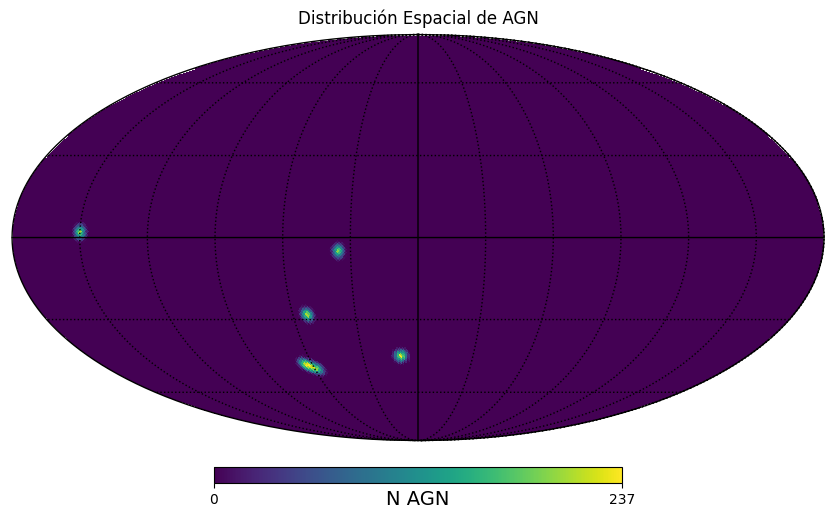

✅ ANÁLISIS ESPACIAL COMPLETADO:
   • Píxeles con AGN: 308
   • Área cubierta: 258.5 grados²
   • Densidad: 5.28 AGN/grado²
   • AGN más aislado: 237 por píxel


In [13]:
print("🗺️ ANALIZANDO DISTRIBUCIÓN ESPACIAL...")

# Crear árbol espacial
coords = head_df[['rad_dec', 'rad_ra']].values
tree = BallTree(coords, metric='haversine')

# Configurar HEALPix
nside = 64
npix = hp.nside2npix(nside)

# Contar objetos por píxel
ipix = np.arange(npix)
hp_ra, hp_dec = np.radians(hp.pix2ang(nside, ipix, lonlat=True))

n_objects_per_pixel = tree.query_radius(
    np.column_stack([hp_dec, hp_ra]),
    r=np.radians(2.0),
    count_only=True
)

# Crear y visualizar mapa
sky_map = np.zeros(npix)
sky_map[ipix] = n_objects_per_pixel

plt.figure(figsize=(12, 6))
hp.mollview(sky_map, title="Distribución Espacial de AGN", unit="N AGN", min=0)
hp.graticule()
plt.show()

# Estadísticas espaciales
populated_pixels = np.sum(n_objects_per_pixel > 0)
total_area_deg2 = hp.nside2pixarea(nside, degrees=True) * populated_pixels

print("✅ ANÁLISIS ESPACIAL COMPLETADO:")
print(f"   • Píxeles con AGN: {populated_pixels:,}")
print(f"   • Área cubierta: {total_area_deg2:.1f} grados²")
print(f"   • Densidad: {len(head_df)/total_area_deg2:.2f} AGN/grado²")
print(f"   • AGN más aislado: {np.max(n_objects_per_pixel)} por píxel")

## Analisis de redshifts

### Histograma de redshift final para AGN

📊 GENERANDO HISTOGRAMA DE REDSHIFT_FINAL...


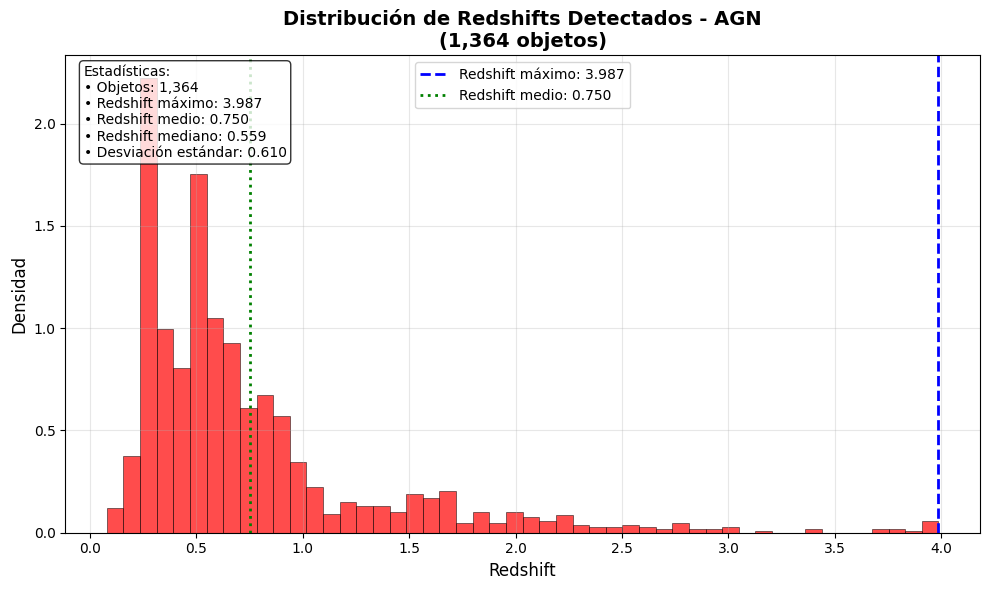

✅ Histograma de redshift_final generado


In [14]:
print("📊 GENERANDO HISTOGRAMA DE REDSHIFT_FINAL...")

# Use the actual column name 'REDSHIFT_FINAL'
redshift_column = 'REDSHIFT_FINAL'

if redshift_column in head_df.columns:
    plt.figure(figsize=(10, 6))

    # Histograma de redshifts detectados
    n, bins, patches = plt.hist(
        head_df[redshift_column],
        bins=50,
        density=True,
        alpha=0.7,
        color='red',
        edgecolor='black',
        linewidth=0.5
    )

    # Línea vertical con redshift máximo
    max_redshift = head_df[redshift_column].max()
    plt.axvline(max_redshift, color='blue', linestyle='--', linewidth=2,
                label=f'Redshift máximo: {max_redshift:.3f}')

    # Estadísticas
    mean_redshift = head_df[redshift_column].mean()
    median_redshift = head_df[redshift_column].median()
    plt.axvline(mean_redshift, color='green', linestyle=':', linewidth=2,
                label=f'Redshift medio: {mean_redshift:.3f}')

    plt.xlabel('Redshift', fontsize=12)
    plt.ylabel('Densidad', fontsize=12)
    plt.title(f'Distribución de Redshifts Detectados - AGN\n({len(head_df):,} objetos)',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir texto con estadísticas
    stats_text = f'''Estadísticas:
• Objetos: {len(head_df):,}
• Redshift máximo: {max_redshift:.3f}
• Redshift medio: {mean_redshift:.3f}
• Redshift mediano: {median_redshift:.3f}
• Desviación estándar: {head_df[redshift_column].std():.3f}'''

    plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
                 verticalalignment='top', fontsize=10,
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✅ Histograma de redshift_final generado")
else:
    print(f"❌ Columna {redshift_column} no encontrada en HEAD")

### Histograma comparativo ZCMB- Simulado vs detectado

📊 GENERANDO HISTOGRAMA COMPARATIVO ZCMB...


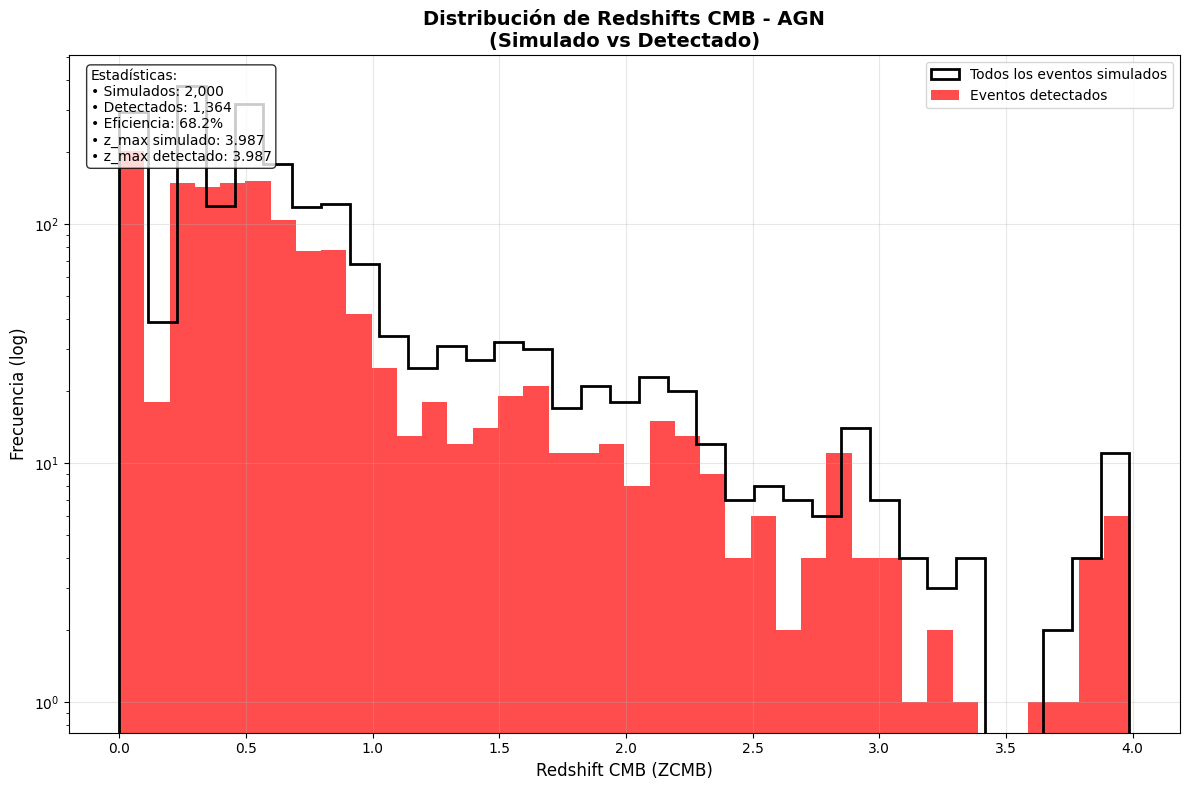

✅ Histograma comparativo ZCMB generado

📈 EFICIENCIA POR BIN DE REDSHIFT:
   • z = [0.00, 0.80): 68.7%
   • z = [0.80, 1.59): 65.4%
   • z = [1.59, 2.39): 70.9%
   • z = [2.39, 3.19): 67.9%
   • z = [3.19, 3.99): 60.9%


In [15]:
print("📊 GENERANDO HISTOGRAMA COMPARATIVO ZCMB...")

# Buscar columnas ZCMB en DUMP
zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
sim_zcmb_col = zcmb_cols[0] if zcmb_cols else sim_z_col

if sim_zcmb_col and not dump_df.empty:
    # Crear máscara para eventos detectados
    detected_mask = dump_df.index.isin(head_df.index)

    plt.figure(figsize=(12, 8))

    # Histograma de todos los eventos simulados
    plt.hist(
        dump_df[sim_zcmb_col],
        bins=35,
        color='black',
        histtype='step',
        linewidth=2,
        label='Todos los eventos simulados',
        log=True
    )

    # Histograma de eventos detectados
    if detected_mask.any():
        plt.hist(
            dump_df[detected_mask][sim_zcmb_col],
            bins=40,
        color='red',
        alpha=0.7,
        label='Eventos detectados',
        log=True
    )

    plt.xlabel(f'Redshift CMB ({sim_zcmb_col})', fontsize=12)
    plt.ylabel('Frecuencia (log)', fontsize=12)
    plt.title('Distribución de Redshifts CMB - AGN\n(Simulado vs Detectado)',
              fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Añadir estadísticas
    if detected_mask.any():
        stats_text = f'''Estadísticas:
• Simulados: {len(dump_df):,}
• Detectados: {detected_mask.sum():,}
• Eficiencia: {detected_mask.sum()/len(dump_df)*100:.1f}%
• z_max simulado: {dump_df[sim_zcmb_col].max():.3f}
• z_max detectado: {dump_df[detected_mask][sim_zcmb_col].max():.3f}'''

        plt.annotate(stats_text, xy=(0.02, 0.98), xycoords='axes fraction',
                     verticalalignment='top', fontsize=10,
                     bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.tight_layout()
    plt.show()

    print("✅ Histograma comparativo ZCMB generado")

    # Calcular eficiencia por bin de redshift
    if detected_mask.any():
        print(f"\n📈 EFICIENCIA POR BIN DE REDSHIFT:")
        z_bins = np.linspace(0, dump_df[sim_zcmb_col].max(), 6)
        for i in range(len(z_bins)-1):
            bin_mask = (dump_df[sim_zcmb_col] >= z_bins[i]) & (dump_df[sim_zcmb_col] < z_bins[i+1])
            bin_detected = detected_mask & bin_mask
            efficiency = bin_detected.sum() / bin_mask.sum() * 100 if bin_mask.sum() > 0 else 0
            print(f"   • z = [{z_bins[i]:.2f}, {z_bins[i+1]:.2f}): {efficiency:.1f}%")

else:
    print("❌ No se puede generar histograma - faltan datos de ZCMB")

**Redshift Detectado (o Redshift Observado):**

Este es el redshift que medimos directamente a partir de la luz que nos llega de un objeto astronómico (como un SLSN-I, una galaxia, un cuásar, etc.).

Se determina observando el espectro de la luz del objeto y midiendo cuánto se han desplazado las líneas espectrales conocidas (líneas de emisión o absorción de elementos químicos) hacia longitudes de onda más largas (el lado rojo del espectro) en comparación con sus posiciones en el laboratorio.

Este desplazamiento es causado por una combinación de factores:

*La expansión del universo:*  Este es el componente principal y el más interesante para los cosmólogos, ya que nos dice qué tan lejos está el objeto y cuánto tiempo ha viajado su luz.

*El movimiento peculiar del objeto:* El movimiento real del objeto a través del espacio, además de la expansión del universo.

*El movimiento peculiar de la Tierra/Observador:* El movimiento de nuestro propio planeta alrededor del Sol, dentro de la Vía Láctea y hacia el "Gran Atractor".

El redshift detectado es, por lo tanto, una medida combinada de estas velocidades relativas.


**Redshift CMB (Redshift en el Marco de Reposo del Fondo Cósmico de Microondas):**

Este es un redshift corregido que intenta eliminar el efecto de los movimientos peculiares (tanto del objeto como del observador) para quedarse solo con el componente debido a la expansión pura del universo.

Se calcula tomando el redshift detectado y restándole las contribuciones estimadas de los movimientos peculiares. Para el movimiento peculiar del observador, se usa la velocidad de nuestro Sistema Solar con respecto al marco de referencia del Fondo Cósmico de Microondas (CMB), que se considera el "marco de reposo" del universo a gran escala.

El redshift CMB es particularmente útil en cosmología porque nos da una medida más directa de la distancia cosmológica del objeto, es decir, la distancia que se deriva únicamente de la expansión del espacio-tiempo.

Las simulaciones a menudo generan el redshift simulado en el marco de reposo del CMB (ZCMB) porque este es el valor "ideal" que refleja la posición del objeto en el universo en expansión, antes de que se añadan los efectos de los movimientos locales y del observador.

### Resumen completo de analisis de redshifts

In [16]:
print("="*60)
print("📊 RESUMEN COMPLETO - ANÁLISIS DE REDSHIFTS AGN")
print("="*60)

if not dump_df.empty and sim_zcmb_col and 'REDSHIFT_FINAL' in head_df.columns:
    # Estadísticas de detección
    detected_mask = dump_df.index.isin(head_df.index)

    print(f"🎯 ESTADÍSTICAS DE DETECCIÓN:")
    print(f"   • Eventos simulados totales: {len(dump_df):,}")
    print(f"   • Eventos detectados: {detected_mask.sum():,}")
    print(f"   • Eficiencia global: {detected_mask.sum()/len(dump_df)*100:.2f}%")

    print(f"\n📈 ESTADÍSTICAS DE REDSHIFT:")
    print(f"   • Redshift máximo simulado: {dump_df[sim_zcmb_col].max():.3f}")
    print(f"   • Redshift máximo detectado: {head_df['REDSHIFT_FINAL'].max():.3f}")
    print(f"   • Redshift medio detectado: {head_df['REDSHIFT_FINAL'].mean():.3f}")
    print(f"   • Redshift mediano detectado: {head_df['REDSHIFT_FINAL'].median():.3f}")

    # Eficiencia por rango de redshift
    print(f"\n📊 EFICIENCIA POR RANGO DE REDSHIFT:")
    z_ranges = [(0, 0.5), (0.5, 1.0), (1.0, 1.5), (1.5, 2.0), (2.0, dump_df[sim_zcmb_col].max())]

    for z_min, z_max in z_ranges:
        if z_min < dump_df[sim_zcmb_col].max():
            range_mask = (dump_df[sim_zcmb_col] >= z_min) & (dump_df[sim_zcmb_col] < z_max)
            if range_mask.any():
                range_detected = detected_mask & range_mask
                efficiency = range_detected.sum() / range_mask.sum() * 100
                n_sim = range_mask.sum()
                n_det = range_detected.sum()
                print(f"   • z [{z_min:.1f}, {z_max:.1f}): {n_det}/{n_sim} = {efficiency:.1f}%")

    print(f"\n✅ ANÁLISIS DE REDSHIFTS COMPLETADO")
else:
    print("❌ No se pudo completar el análisis - faltan datos esenciales")

📊 RESUMEN COMPLETO - ANÁLISIS DE REDSHIFTS AGN
🎯 ESTADÍSTICAS DE DETECCIÓN:
   • Eventos simulados totales: 2,000
   • Eventos detectados: 1,364
   • Eficiencia global: 68.20%

📈 ESTADÍSTICAS DE REDSHIFT:
   • Redshift máximo simulado: 3.987
   • Redshift máximo detectado: 3.987
   • Redshift medio detectado: 0.750
   • Redshift mediano detectado: 0.559

📊 EFICIENCIA POR RANGO DE REDSHIFT:
   • z [0.0, 0.5): 660/978 = 67.5%
   • z [0.5, 1.0): 453/646 = 70.1%
   • z [1.0, 1.5): 83/130 = 63.8%
   • z [1.5, 2.0): 73/110 = 66.4%
   • z [2.0, 4.0): 94/135 = 69.6%

✅ ANÁLISIS DE REDSHIFTS COMPLETADO


## Numero de detecciones por AGN

📊 ANALIZANDO Y GRAFICANDO NÚMERO DE DETECCIONES POR AGN...
Procesando 1364 objetos AGN...
Generando histogramas...


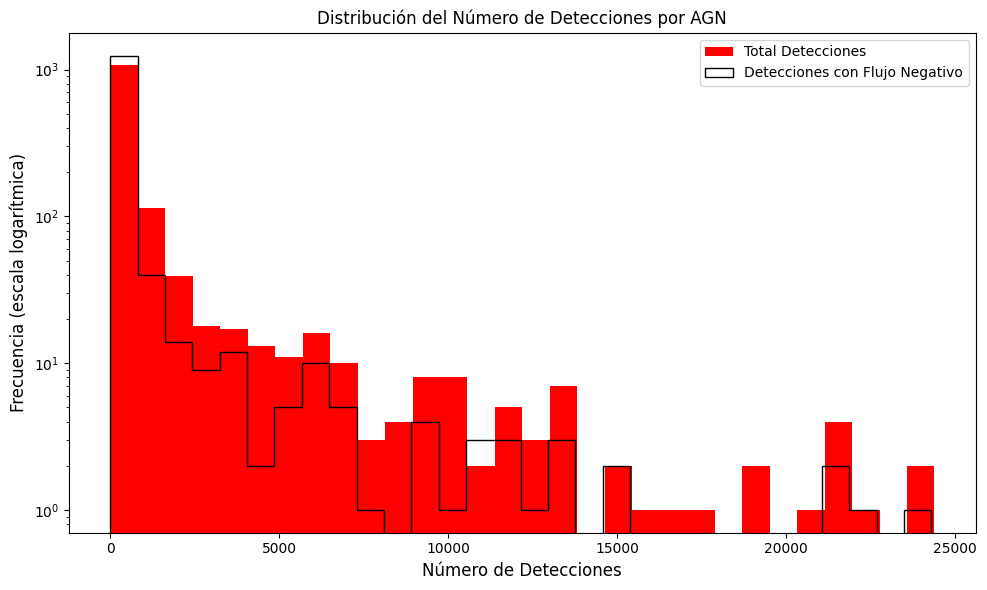

✅ Análisis y gráfico de número de detecciones completado.

=== ESTADÍSTICAS DE DETECCIONES ===
Número promedio de detecciones por AGN: 1078.26
Número promedio de detecciones con flujo negativo por AGN: 474.38
AGN con más detecciones: 24388
AGN con más detecciones de flujo negativo: 24293


In [17]:
print("📊 ANALIZANDO Y GRAFICANDO NÚMERO DE DETECCIONES POR AGN...")

# Fundamento Astronómico:
# El número de detecciones para un objeto astronómico, especialmente un transiente como un AGN,
# es crucial para caracterizar su comportamiento a lo largo del tiempo. Un mayor número de
# detecciones a menudo implica una curva de luz mejor muestreada, lo que permite una mejor
# determinación de propiedades como la magnitud máxima, la duración del evento y los parámetros
# de variabilidad.
#
# Las detecciones con flujo negativo (FLUX_uJy < 0) son un indicador importante de ruido
# o problemas en el fondo del cielo (sky subtraction). Analizar su frecuencia y distribución
# nos ayuda a evaluar la calidad de la fotometría y a identificar posibles limitaciones
# en la capacidad de detección, especialmente para objetos débiles. Una alta tasa de
# detecciones con flujo negativo puede sugerir que el límite de detección es demasiado somero
# o que hay problemas sistemáticos en el procesamiento de las imágenes.

if not head_df.empty and not phot_df.empty:
    # Listas para almacenar el número de detecciones
    n_detecciones = []
    n_neg_flux = []

    print(f"Procesando {len(head_df)} objetos AGN...")

    # Iterar sobre cada objeto SLSN-I en el DataFrame de metadatos (head_df)
    for index, obj_meta in head_df.iterrows():
        # Extraer el rango de observaciones para este objeto usando PTROBS_MIN y PTROBS_MAX
        # Restamos 1 a PTROBS_MIN porque los índices de pandas son base 0,
        # mientras que PTROBS_MIN/MAX en SNANA suelen ser base 1.
        # Aseguramos que los valores de índice son válidos para el DataFrame phot_df
        first_obs_idx = obj_meta['PTROBS_MIN'] - 1
        last_obs_idx = obj_meta['PTROBS_MAX']

        # Seleccionar las observaciones correspondientes a este objeto
        # Usamos iloc para seleccionar por índice de posición
        obj_obs = phot_df.iloc[first_obs_idx : last_obs_idx + 1]

        # Filtrar observaciones consideradas "detecciones"
        # Según la documentación de SNANA, PHOTFLAG = 4096 o 6144 indican una detección.
        # PHOTFLAG = 4096: Detection
        # PHOTFLAG = 6144: Detection (with some flag, e.g., saturated pixel)
        # Consideramos ambas como "detecciones" en este contexto.
        detections = obj_obs[(obj_obs['PHOTFLAG'] == 4096) | (obj_obs['PHOTFLAG'] == 6144)].copy()

        # Contar el número total de detecciones para este objeto
        n_detecciones.append(len(detections))

        # Contar el número de detecciones con flujo negativo
        neg_detections = detections[detections['FLUX_uJy'] < 0]
        n_neg_flux.append(len(neg_detections))

    # Convertir las listas a Series de pandas para facilitar el ploteo
    detections_series = pd.Series(n_detecciones, index=head_df.index)
    neg_flux_series = pd.Series(n_neg_flux, index=head_df.index)

    print("Generando histogramas...")

    # Crear figura y ejes para los histogramas
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histograma del número total de detecciones
    detections_series.hist(bins=30, density=False, ax=ax, grid=False, color='r', log=True, label='Total Detecciones')

    # Histograma del número de detecciones con flujo negativo (como un paso)
    # Usamos bins similares para una comparación visual más fácil
    neg_flux_series.hist(bins=30, ax=ax, grid=False, color='k', log=True, histtype='step', label='Detecciones con Flujo Negativo')


    # Configurar título y etiquetas del gráfico
    ax.set_title('Distribución del Número de Detecciones por AGN', size='large', y=1.0)
    ax.set_xlabel('Número de Detecciones', size='large')
    ax.set_ylabel('Frecuencia (escala logarítmica)', size='large')
    ax.legend() # Mostrar la leyenda para identificar los histogramas

    # Ajustar diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

    print("✅ Análisis y gráfico de número de detecciones completado.")

    # Opcional: Imprimir algunas estadísticas resumen
    print("\n=== ESTADÍSTICAS DE DETECCIONES ===")
    print(f"Número promedio de detecciones por AGN: {detections_series.mean():.2f}")
    print(f"Número promedio de detecciones con flujo negativo por AGN: {neg_flux_series.mean():.2f}")
    print(f"AGN con más detecciones: {detections_series.max():.0f}")
    print(f"AGN con más detecciones de flujo negativo: {neg_flux_series.max():.0f}")


else:
    print("❌ No se pueden realizar análisis - head_df o phot_df están vacíos.")

## Histograma de magnitudes contrastado

Los histogramas de magnitud son herramientas esenciales en astronomía para visualizar la distribución de brillo de una población de objetos. Contrastar la distribución de magnitudes de todas las observaciones con la de las observaciones *detectadas* es fundamental para entender los sesgos de selección de un relevamiento.

La distribución de todas las observaciones (simuladas o reales) nos da una idea de la población intrínseca y la contribución del ruido. La distribución de las observaciones *detectadas*, por otro lado, muestra qué parte de esa población es efectivamente visible con los criterios de detección aplicados. La diferencia entre ambas distribuciones revela la "función de selección" del relevamiento, mostrando a qué magnitudes se vuelve incompleto o incapaz de detectar objetos.

Se espera ver que las detecciones se concentran en magnitudes más brillantes (valores de MAG_AB menores) en comparación con todas las observaciones, que pueden extenderse a magnitudes mucho más débiles (valores de MAG_AB mayores), a menudo dominadas por el ruido. La escala logarítmica en la frecuencia para las detecciones es útil para visualizar la cola de objetos más débiles detectados.

📊 GENERANDO HISTOGRAMA DE MAGNITUDES CONTRASTADO...


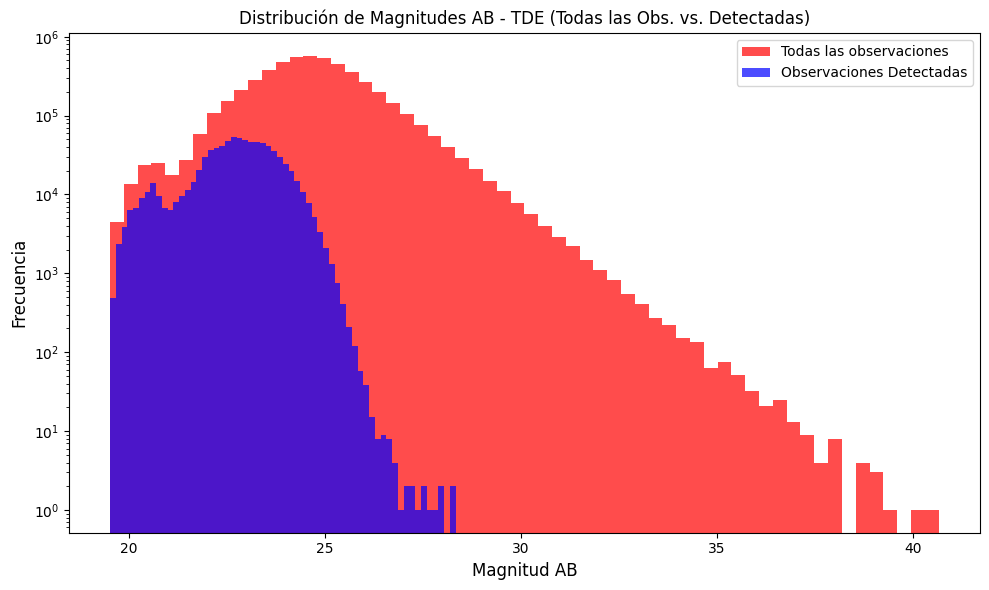

✅ Histograma de magnitudes contrastado generado.


In [18]:
print("📊 GENERANDO HISTOGRAMA DE MAGNITUDES CONTRASTADO...")

if not phot_df.empty and 'MAG_AB' in phot_df.columns and 'PHOTFLAG' in phot_df.columns:
    # Crear figura y ejes para el histograma
    fig, ax = plt.subplots(figsize=(10, 6))

    # Histograma de todas las observaciones (con magnitud válida)
    # Filtramos los NaN en MAG_AB para el histograma
    all_magnitudes = phot_df['MAG_AB'].dropna()
    if not all_magnitudes.empty:
        all_magnitudes.hist(bins=60, density=False, ax=ax, grid=False, color='r', alpha=0.7, label='Todas las observaciones')

    # Filtrar observaciones consideradas "detecciones"
    # Según la documentación de SNANA, PHOTFLAG = 4096 o 6144 indican una detección.
    detections_df = phot_df[(phot_df['PHOTFLAG'] == 4096) | (phot_df['PHOTFLAG'] == 6144)].copy()

    # Histograma de magnitudes de las detecciones (con magnitud válida)
    detected_magnitudes = detections_df['MAG_AB'].dropna()
    if not detected_magnitudes.empty:
        # Usamos los mismos bins para consistencia visual
        detected_magnitudes.hist(bins=60, density=False, ax=ax, grid=False, color='b', alpha=0.7, log=True, label='Observaciones Detectadas')


    # Configurar título y etiquetas
    ax.set_title('Distribución de Magnitudes AB - TDE (Todas las Obs. vs. Detectadas)', size='large')
    ax.set_xlabel('Magnitud AB', size='large')
    ax.set_ylabel('Frecuencia', size='large') # Density=False means raw counts

    ax.legend()
    ax.grid(False) # Disable grid as in example
    # ax.invert_xaxis() # Magnitudes: más brillante = menor valor, so invert x-axis ***preguntar

    plt.tight_layout()
    plt.show()

    print("✅ Histograma de magnitudes contrastado generado.")

else:
    print("❌ No se pueden generar gráficos - phot_df vacío o faltan columnas esenciales ('MAG_AB', 'PHOTFLAG').")

#Curvas de luz

In [ ]:
print("📈 GENERANDO CURVAS DE LUZ MEJORADAS...")

# Select 10 random objects
n_objects_to_plot = 10
if len(head_df) >= n_objects_to_plot:
    # Select specific objects by SNID string
    # Ensure 'SNID_str' is in head_df
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    # Create a list of SNIDs from 1 to 10 as strings
    target_snids_str = [str(i) for i in range(1, n_objects_to_plot + 1)]

    # Filter head_df for the target SNIDs
    selected_objects_meta = head_df[head_df['SNID_str'].isin(target_snids_str)]

    # Ensure the plotting order matches the target SNIDs if possible
    # Create a dictionary for quick lookup of metadata by SNID string
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')
    # Filter the target_snids_str list to only include those found in metadata
    objects_to_plot_snids = [snid for snid in target_snids_str if snid in meta_dict]

    n_objects_to_plot_actual = len(objects_to_plot_snids)

    if n_objects_to_plot_actual > 0:
        print(f"🔍 Objetos seleccionados: {objects_to_plot_snids}")

        # Define bands and colors based on user example
        bands = ['u', 'g','r','i', "z", "Y"]
        colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


        # Configurar plot
        # Adjusted figsize to make space for legends on the side
        fig, axes = plt.subplots(n_objects_to_plot_actual, 1, figsize=(15, 3*n_objects_to_plot_actual), sharex=False)


        # Ensure axes is an array even for a single subplot
        if n_objects_to_plot_actual == 1:
            axes = [axes]

        # Ensure 'SNID_str' is in linked_df
        if 'SNID_str' not in linked_df.columns:
             linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

        # Collect handles and labels for a single legend - Not needed anymore
        # handles, labels = [], []

        for i, snid_str in enumerate(objects_to_plot_snids):
            # Get object data using the helper function
            obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy() # Use linked_df as it has SNID, RA, DEC, etc.

            # Get metadata for title
            obj_meta = meta_dict.get(snid_str)
            if obj_meta is None:
                 print(f"Metadata not found for SNID: {snid_str}")
                 continue # Skip this object if metadata is missing

            redshift = obj_meta['REDSHIFT_FINAL']
            ra = obj_meta['RA']
            dec = obj_meta['DEC']
            # Assuming MWEBV is in head_df, adjust column name if necessary
            mwebv = obj_meta.get('MWEBV', 'N/A') # Use .get to avoid error if MWEBV is missing


            for band in bands: # Iterate through defined bands
                band_data = obj_data[obj_data['BAND'] == band]

                # Separate detected and non-detected observations based on PHOTFLAG
                # PHOTFLAG = 4096 or 6144 for detections
                # PHOTFLAG = 0 for non-detections
                detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
                non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


                # Plot detected points (circles)
                if not detected_band_data.empty:
                    # Changed back to errorbar and removed unpacking for detected points
                    axes[i].errorbar(
                        detected_band_data['MJD'],
                        detected_band_data['FLUX_uJy'],
                        yerr=detected_band_data['FLUX_uJy_ERR'], # Added yerr back for detected points too
                        label=f'{band} det',
                        color=colors.get(band, 'gray'),
                        marker='o',
                        markersize=4,
                        alpha=0.8,
                        linestyle='None' # No line for scatter points
                    )
                    # Collect handle and label only once - Not needed anymore
                    # if f'{band} det' not in labels:
                    #     handles.append(line)
                    #     labels.append(f'{band} det')


                # Plot non-detected points (downward triangles) - Added yerr back and changed to errorbar
                if not non_detected_band_data.empty:
                     axes[i].errorbar(
                        non_detected_band_data['MJD'],
                        non_detected_band_data['FLUX_uJy'],
                        yerr=non_detected_band_data['FLUX_uJy_ERR'],
                        label=f'{band} non det',
                        color=colors.get(band, 'gray'),
                        marker='v', # downward triangle
                        markersize=4,
                        alpha=0.3, # reduced alpha for non-detections
                        linestyle='None' # No line for scatter points
                    )
                     # Collect handle and label only once - Not needed anymore
                     # if f'{band} non det' not in labels:
                     #    handles.append(line)
                     #    labels.append(f'{band} non det')


            # snid_str = snid.decode() if isinstance(snid, bytes) else snid
            axes[i].set_title(f'AGN: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} |  z={redshift:.3f} | MWEBV={mwebv:.3f}' if isinstance(mwebv, (int, float)) else f'AGN: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z={redshift:.3f} | MWEBV={mwebv}')
            axes[i].set_ylabel('FLUX_uJy')
            # Add legend outside the plot area
            axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            axes[i].grid(True, alpha=0.3)
            axes[i].set_xlabel('MJD (Modified Julian Date)') # Set xlabel for each subplot


        # Removed the common x-label
        # axes[-1].set_xlabel('MJD (Modified Julian Date)')

        # Removed the single figure legend
        # fig.legend(handles, labels, loc='lower center', ncol=len(bands)*2, bbox_to_anchor=(0.5, -0.05))


        plt.tight_layout()
        plt.show()

        print("✅ CURVAS DE LUZ MEJORADAS GENERADAS")
    else:
         print(f"❌ No se encontraron los SNID {target_snids_str} en los metadatos.")

else:
    print(f"❌ No se puede graficar porque el número de objetos ({len(head_df)}) es menor que el número solicitado ({n_objects_to_plot}).")

📈 GENERANDO CURVAS DE LUZ MEJORADAS...
🔍 Objetos seleccionados: ['1', '2', '7', '8', '9']


## IDs de AGN detectados

In [ ]:
print("🔍 OBTENIENDO SNID DE AGN DETECTADOS...")

# Filtrar head_df para incluir solo los SNID presentes en linked_df
# linked_df contiene solo los objetos con observaciones vinculadas (que provienen de head_df)
# Un objeto en head_df se considera "detectado" en este contexto si tiene al menos una observación vinculada.
detected_snids_bytes = linked_df['SNID'].unique()

# Decodificar los SNID de bytes a string
detected_snids_str = [snid.decode().strip() for snid in detected_snids_bytes]

print(f"✅ Se encontraron {len(detected_snids_str):,} SNID de AGN detectados.")

# Mostrar los primeros 10 SNID detectados
print("\n📋 Primeros 10 SNID detectados:")
print(detected_snids_str[:10])

# Guardar la lista de SNID detectados en una variable para uso posterior
detected_AGN_snids = detected_snids_str

## Filtros exploratorios

### Filtro para ver altos flujos

In [ ]:
print("🔍 Filtrando AGN detectados por flujo mínimo...")

# Definir el umbral de flujo en microJy
flux_threshold_uJy = 20

# Crear una lista para almacenar los SNID que cumplen el criterio
snids_with_high_flux = []

# Iterar sobre cada SNID en la lista de detectados
# linked_df ya contiene solo los objetos detectados y sus observaciones vinculadas
# Optimización: Agrupar linked_df por SNID para un acceso más rápido a las observaciones de cada objeto
grouped_linked_df = linked_df.groupby('SNID')

print(f"Procesando {len(detected_AGN_snids)} AGN detectados...")

for snid_bytes in detected_snids_bytes: # Iterate over the original bytes list
    # Get all observations for the current SNID
    # Check if the SNID exists in the grouped DataFrame's keys before accessing
    if snid_bytes in grouped_linked_df.groups:
        obj_obs = grouped_linked_df.get_group(snid_bytes)

        # Verificar si alguna observación para este SNID tiene FLUX_uJy > flux_threshold_uJy
        if (obj_obs['FLUX_uJy'] > flux_threshold_uJy).any():
            # Decodificar el SNID de bytes a string antes de añadirlo a la lista final
            snids_with_high_flux.append(snid_bytes.decode().strip())


print(f"✅ Se encontraron {len(snids_with_high_flux):,} AGN con al menos una medición > {flux_threshold_uJy} μJy.")

# Mostrar los primeros 10 SNID filtrados
print("\n📋 Primeros 10 SNID con alto flujo:")
print(snids_with_high_flux[:10])

# Guardar la lista filtrada en una nueva variable
filtered_AGN_snids_high_flux = snids_with_high_flux

In [ ]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ PARA AGN CON ALTO FLUJO
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ PARA AGN CON ALTO FLUJO...")

# Use the list of SNIDs filtered by high flux
objects_to_plot_snids = filtered_AGN_snids_high_flux # Use the filtered list
n_objects_to_plot = len(objects_to_plot_snids) # Update the count

if n_objects_to_plot > 0:
    # Get metadata for the selected objects based on their SNIDs
    # Need to handle byte strings for SNID in head_df if not already done
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    selected_objects_meta = head_df[head_df['SNID_str'].isin(objects_to_plot_snids)]

    # Ensure the plotting order matches the filtered list
    # Create a dictionary for quick lookup of metadata by SNID string
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')

    print(f"🔍 Objetos seleccionados para plotear: {n_objects_to_plot}")

    # Define bands and colors based on previous example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    # Adjusted figsize to make space for legends on the side
    # Adjusted height based on the number of objects
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3.5*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Iterate through the filtered SNIDs
    for i, snid_str in enumerate(objects_to_plot_snids):
        # Get object data using the helper function
        # Filter linked_df using the string SNID
        # Add 'SNID_str' to linked_df if not already present
        if 'SNID_str' not in linked_df.columns:
             linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

        obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy()

        # Get metadata for title using the dictionary lookup
        obj_meta = meta_dict.get(snid_str)
        if obj_meta is None:
             print(f"Metadata not found for SNID: {snid_str}")
             continue # Skip this object if metadata is missing

        redshift = obj_meta['REDSHIFT_FINAL']
        ra = obj_meta['RA']
        dec = obj_meta['DEC']
        mwebv = obj_meta.get('MWEBV', 'N/A')


        for band in bands: # Iterate through defined bands
            band_data = obj_data[obj_data['BAND'] == band]

            # Separate detected and non-detected observations based on PHOTFLAG
            # PHOTFLAG = 4096 or 6144 for detections
            # PHOTFLAG = 0 for non-detections
            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            # Plot detected points (circles)
            if not detected_band_data.empty:
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None'
                )


            # Plot non-detected points (downward triangles)
            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v',
                    markersize=4,
                    alpha=0.3,
                    linestyle='None'
                )


        axes[i].set_title(f'AGN: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} |  z={redshift:.3f} | MWEBV={mwebv:.3f}' if isinstance(mwebv, (int, float)) else f'AGN: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z={redshift:.3f} | MWEBV={mwebv}')
        axes[i].set_ylabel('FLUX_uJy')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)')


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ PARA AGN CON ALTO FLUJO GENERADAS")
else:
    print(f"❌ No hay objetos en la lista filtrada para graficar.")

### Filtrado para ver AGN con redshift CMB (ZCMB) altos

In [ ]:
print("🔍 Filtrando AGN detectados por Redshift CMB mínimo...")

# Definir el umbral de redshift CMB
zcmb_threshold = 1.5
# Asegurarse de que dump_df no esté vacío y que la columna ZCMB exista
zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
sim_zcmb_col = zcmb_cols[0] if zcmb_cols else None

if not dump_df.empty and sim_zcmb_col:
    # Asegurarse de que head_df tiene una columna string para SNID para facilitar la comparación
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    # Asegurarse de que dump_df tiene una columna string para SNID (o un índice que coincida con SNID_str)
    # Asumiendo que el índice de dump_df es el CID/SNID simulado
    # Si no es así, necesitaremos encontrar la columna que mapea a SNID.
    # Basado en la inspección inicial, parece que la columna 'CID' en DUMP corresponde a SNID.
    if 'CID' in dump_df.columns:
         dump_df['CID_str'] = dump_df['CID'].astype(str)
         # Crear un conjunto de SNID detectados como strings para una búsqueda rápida
         detected_snid_set = set(detected_AGN_snids)

         # Filtrar dump_df para incluir solo los objetos que fueron detectados
         detected_in_dump_df = dump_df[dump_df['CID_str'].isin(detected_snid_set)].copy()

         # Ahora filtrar los objetos detectados por el umbral de ZCMB
         snids_high_zcmb_df = detected_in_dump_df[detected_in_dump_df[sim_zcmb_col] > zcmb_threshold]

         # Obtener la lista de SNID (como strings) que cumplen ambos criterios
         snids_high_zcmb = snids_high_zcmb_df['CID_str'].tolist()

         print(f"✅ Se encontraron {len(snids_high_zcmb):,} AGN detectados con Redshift CMB > {zcmb_threshold}.")

         # Mostrar los primeros 10 SNID filtrados
         print("\n📋 Primeros 10 SNID con alto Redshift CMB:")
         print(snids_high_zcmb[:10])

         # Guardar la lista filtrada en una nueva variable
         filtered_AGN_snids_high_zcmb = snids_high_zcmb

    else:
        print("❌ No se encontró la columna 'CID' en DUMP para vincular con SNID.")

else:
    print("❌ No se pudo realizar el filtrado - dump_df vacío o falta columna ZCMB.")

In [ ]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ PARA AGN CON ALTO REDSHIFT CMB
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ PARA AGN CON ALTO REDSHIFT CMB...")

# Use the list of SNIDs filtered by high ZCMB
objects_to_plot_snids = filtered_AGN_snids_high_zcmb # Use the filtered list
n_objects_to_plot = len(objects_to_plot_snids) # Update the count

if n_objects_to_plot > 0:
    # Get metadata for the selected objects based on their SNIDs
    # Ensure 'SNID_str' is in head_df
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    selected_objects_meta = head_df[head_df['SNID_str'].isin(objects_to_plot_snids)]

    # Ensure the plotting order matches the filtered list
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')

    print(f"🔍 Objetos seleccionados para plotear: {n_objects_to_plot}")

    # Define bands and colors based on previous example
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}


    # Configurar plot
    # Adjusted figsize and height based on the number of objects
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 3.5*n_objects_to_plot), sharex=False)


    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Ensure 'SNID_str' is in linked_df
    if 'SNID_str' not in linked_df.columns:
         linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

    # Iterate through the filtered SNIDs
    for i, snid_str in enumerate(objects_to_plot_snids):
        # Get object data using the helper function
        obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy()

        # Get metadata for title using the dictionary lookup
        obj_meta = meta_dict.get(snid_str)
        if obj_meta is None:
             print(f"Metadata not found for SNID: {snid_str}")
             continue

        redshift = obj_meta['REDSHIFT_FINAL'] # Using detected redshift for plot title
        ra = obj_meta['RA']
        dec = obj_meta['DEC']
        mwebv = obj_meta.get('MWEBV', 'N/A')
        # Get ZCMB from dump_df for title if available
        zcmb_value = None
        zcmb_cols = [col for col in dump_df.columns if 'ZCMB' in col.upper()]
        sim_zcmb_col = zcmb_cols[0] if zcmb_cols else None
        if 'CID_str' in dump_df.columns and sim_zcmb_col and snid_str in dump_df['CID_str'].values:
             zcmb_row = dump_df[dump_df['CID_str'] == snid_str].iloc[0]
             zcmb_value = zcmb_row.get(sim_zcmb_col)


        for band in bands:
            band_data = obj_data[obj_data['BAND'] == band]

            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()


            if not detected_band_data.empty:
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None'
                )


            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v',
                    markersize=4,
                    alpha=0.3,
                    linestyle='None'
                )

        # Construct title including both detected redshift and ZCMB if available
        title_text = f'AGN: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z_det={redshift:.3f}'

        if isinstance(mwebv, (int, float)):
             title_text += f' | MWEBV={mwebv:.3f}'
        else:
             title_text += f' | MWEBV={mwebv}'

        axes[i].set_title(title_text)
        axes[i].set_ylabel('FLUX_uJy')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)')


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ PARA AGN CON ALTO REDSHIFT CMB GENERADAS")
else:
    print(f"❌ No hay objetos en la lista filtrada para graficar.")

## Visualizaciones espaciales

### Visualizacion de la ubicacion de un objetivo en especifico en un mapa healpix

In [ ]:
print("🗺️ VISUALIZANDO UBICACIÓN DE AGN ESPECÍFICO EN MAPA HEALPIX...")

# Definir el SNID del objeto que queremos visualizar
target_snid_str = '1875'

# Asegurarse de que head_df tiene la columna string para SNID
if 'SNID_str' not in head_df.columns:
    head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

# Encontrar los metadatos para el objeto objetivo
target_object_meta = head_df[head_df['SNID_str'] == target_snid_str]

if not target_object_meta.empty:
    # Obtener RA y DEC del objeto objetivo
    target_ra = target_object_meta['RA'].iloc[0]
    target_dec = target_object_meta['DEC'].iloc[0]

    print(f"🔍 Ubicación de SNID {target_snid_str}: RA={target_ra:.4f}, Dec={target_dec:.4f}")


    # Configurar HEALPix (usando el mismo nside que antes para consistencia)
    nside = 64
    npix = hp.nside2npix(nside)

    # Crear un mapa HEALPix vacío
    sky_map_single = np.zeros(npix)

    # Convertir RA y DEC del objeto objetivo a coordenadas HEALPix (theta, phi)
    # healpy usa theta (colatitud) y phi (longitud), donde theta = 90 - Dec y phi = Ra
    target_theta = np.radians(90. - target_dec)
    target_phi = np.radians(target_ra)

    # Encontrar el píxel HEALPix que contiene el objeto objetivo
    target_pixel = hp.ang2pix(nside, target_theta, target_phi)

    # Marcar el píxel del objeto objetivo en el mapa (por ejemplo, con un valor de 1)
    sky_map_single[target_pixel] = 1.0

    # Visualizar el mapa
    plt.figure(figsize=(12, 6))
    hp.mollview(
        sky_map_single,
        title=f"Ubicación de AGN {target_snid_str} (RA={target_ra:.2f}, Dec={target_dec:.2f})",
        unit="Pixel de Objeto Objetivo",
        min=0,
        max=1, # Escala para que solo se muestre el píxel marcado
        cbar=False # No necesitamos barra de color para un solo píxel
    )
    hp.graticule() # Añadir graticula para referencia

    # Añadir un marcador más visible en la ubicación exacta
    hp.projscatter(target_theta, target_phi, lonlat=False, marker='o', color='red', s=100, edgecolors='black', label=f'SNID {target_snid_str}')
    plt.legend(loc='best') # Add a legend for the marker


    plt.show()

    print(f"✅ Mapa HEALPix generado mostrando la ubicación de SNID {target_snid_str}.")

else:
    print(f"❌ SNID {target_snid_str} no encontrado en los metadatos.")

In [ ]:
# =============================================================================
# VISUALIZACIÓN DE LA UBICACIÓN DE UN AGN ESPECÍFICO EN UN MAPA HEALPIX
# =============================================================================

print("🗺️ VISUALIZANDO UBICACIÓN DE AGN ESPECÍFICO EN MAPA HEALPIX...")

# Definir el SNID del objeto que queremos visualizar
target_snid_str = '1569'

# Asegurarse de que head_df tiene la columna string para SNID
if 'SNID_str' not in head_df.columns:
    head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

# Encontrar los metadatos para el objeto objetivo
target_object_meta = head_df[head_df['SNID_str'] == target_snid_str]

if not target_object_meta.empty:
    # Obtener RA y DEC del objeto objetivo
    target_ra = target_object_meta['RA'].iloc[0]
    target_dec = target_object_meta['DEC'].iloc[0]

    print(f"🔍 Ubicación de SNID {target_snid_str}: RA={target_ra:.4f}, Dec={target_dec:.4f}")


    # Configurar HEALPix (usando el mismo nside que antes para consistencia)
    nside = 64
    npix = hp.nside2npix(nside)

    # Crear un mapa HEALPix vacío
    sky_map_single = np.zeros(npix)

    # Convertir RA y DEC del objeto objetivo a coordenadas HEALPix (theta, phi)
    # healpy usa theta (colatitud) y phi (longitud), donde theta = 90 - Dec y phi = Ra
    target_theta = np.radians(90. - target_dec)
    target_phi = np.radians(target_ra)

    # Encontrar el píxel HEALPix que contiene el objeto objetivo
    target_pixel = hp.ang2pix(nside, target_theta, target_phi)

    # Marcar el píxel del objeto objetivo en el mapa (por ejemplo, con un valor de 1)
    sky_map_single[target_pixel] = 1.0

    # Visualizar el mapa
    plt.figure(figsize=(12, 6))
    hp.mollview(
        sky_map_single,
        title=f"Ubicación de AGN {target_snid_str} (RA={target_ra:.2f}, Dec={target_dec:.2f})",
        unit="Pixel de Objeto Objetivo",
        min=0,
        max=1, # Escala para que solo se muestre el píxel marcado
        cbar=False # No necesitamos barra de color para un solo píxel
    )
    hp.graticule() # Añadir graticula para referencia

    # Añadir un marcador más visible en la ubicación exacta
    hp.projscatter(target_theta, target_phi, lonlat=False, marker='o', color='red', s=100, edgecolors='black', label=f'SNID {target_snid_str}')
    plt.legend(loc='best') # Add a legend for the marker


    plt.show()

    print(f"✅ Mapa HEALPix generado mostrando la ubicación de SNID {target_snid_str}.")

else:
    print(f"❌ SNID {target_snid_str} no encontrado en los metadatos.")

### Comparacion de distribucion espacial: simulados vs detectados

faltan sacar las curvas de luz de detectados y de simulados

In [ ]:
print("🗺️ COMPARANDO DISTRIBUCIÓN ESPACIAL (SIMULADOS vs DETECTADOS)...")

# Configurar HEALPix (usando el mismo nside que antes para consistencia)
nside = 64
npix = hp.nside2npix(nside)

# --- Mapa para TODOS los objetos SIMULADOS (desde DUMP) ---
sim_ra_col = [col for col in dump_df.columns if 'RA' in col.upper()][0] if [col for col in dump_df.columns if 'RA' in col.upper()] else None
sim_dec_col = [col for col in dump_df.columns if 'DEC' in col.upper()][0] if [col for col in dump_df.columns if 'DEC' in col.upper()] else None

if not dump_df.empty and sim_ra_col and sim_dec_col:
    print("Procesando todos los objetos simulados...")
    # Filter out rows with invalid DEC values before converting to radians
    valid_dump_df = dump_df[(dump_df[sim_dec_col] >= -90) & (dump_df[sim_dec_col] <= 90)].copy()

    # Convertir RA y DEC de todos los simulados a coordenadas HEALPix
    sim_theta = np.radians(90. - valid_dump_df[sim_dec_col])
    sim_phi = np.radians(valid_dump_df[sim_ra_col])
    sim_pixels = hp.ang2pix(nside, sim_theta, sim_phi)

    # Contar objetos por píxel para todos los simulados
    sim_sky_map = np.bincount(sim_pixels, minlength=npix)

    # --- Mapa para objetos DETECTADOS (desde HEAD) ---
    # head_df ya tiene 'RA' y 'DEC'
    print("Procesando objetos detectados...")
    # Convertir RA y DEC de los detectados a coordenadas HEALPix
    det_theta = np.radians(90. - head_df['DEC'])
    det_phi = np.radians(head_df['RA'])
    det_pixels = hp.ang2pix(nside, det_theta, det_phi)

    # Contar objetos por píxel para los detectados
    det_sky_map = np.bincount(det_pixels, minlength=npix)

    # --- Visualización ---
    print("Generando mapas HEALPix...")
    plt.figure(figsize=(15, 10))

    # Subplot para todos los simulados
    plt.subplot(2, 1, 1) # 2 rows, 1 column, 1st plot
    hp.mollview(
        sim_sky_map,
        fig=plt.gcf(), # Use current figure
        sub=211,     # Subplot code
        title=f"Distribución Espacial de TODOS los AGN Simulados ({len(valid_dump_df):,} objetos)",
        unit="N AGN Simulados por píxel",
        min=0
    )
    hp.graticule()

    # Subplot para los detectados
    plt.subplot(2, 1, 2) # 2 rows, 1 column, 2nd plot
    hp.mollview(
        det_sky_map,
        fig=plt.gcf(), # Use current figure
        sub=212,     # Subplot code
        title=f"Distribución Espacial de AGN DETECTADOS ({len(head_df):,} objetos)",
        unit="N AGN Detectados por píxel",
        min=0
    )
    hp.graticule()

    plt.tight_layout()
    plt.show()

    print("✅ Comparación de distribución espacial generada.")

else:
    print("❌ No se pudieron generar los mapas - faltan datos esenciales en DUMP o HEAD.")

### Visualizacion de la ubicacion de multiples AGN

In [ ]:
print("🗺️ VISUALIZANDO UBICACIONES DE TDE CON ALTO FLUJO EN MAPA HEALPIX...")

# Usar la lista de SNID filtrados por alto flujo
objects_to_plot_snids = filtered_AGN_snids_high_flux # Usar la lista filtrada
n_objects_to_plot = len(objects_to_plot_snids) # Actualizar el contador

if n_objects_to_plot > 0:
    # Asegurarse de que head_df tiene la columna string para SNID
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    # Obtener los metadatos para los objetos objetivo (los de alto flujo)
    target_objects_meta = head_df[head_df['SNID_str'].isin(objects_to_plot_snids)].copy()

    if not target_objects_meta.empty:
        # Configurar HEALPix (usando el mismo nside que antes para consistencia)
        nside = 64
        npix = hp.nside2npix(nside)

        # Crear un mapa HEALPix vacío para la visualización de ubicaciones
        sky_map_locations = np.zeros(npix)

        # Convertir RA y DEC de los objetos objetivo a coordenadas HEALPix (theta, phi)
        target_theta = np.radians(90. - target_objects_meta['DEC'])
        target_phi = np.radians(target_objects_meta['RA'])

        # Encontrar los píxeles HEALPix que contienen los objetos objetivo
        target_pixels = hp.ang2pix(nside, target_theta, target_phi)

        # Incrementar el contador para cada píxel que contiene un objeto
        # Nota: Si múltiples objetos caen en el mismo píxel, este método los cuenta.
        for pixel in target_pixels:
            sky_map_locations[pixel] += 1

        # Visualizar el mapa
        plt.figure(figsize=(12, 6))
        hp.mollview(
            sky_map_locations,
            title=f"Ubicación de {n_objects_to_plot} TDE con Alto Flujo",
            unit="Número de TDE por píxel",
            min=0,
            cbar=True # Mostrar barra de color
        )
        hp.graticule() # Añadir graticula para referencia

        # --- Añadir la ubicación de la supernova 1918 ---
        specific_snid_str = '1918'
        specific_object_meta = head_df[head_df['SNID_str'] == specific_snid_str]

        if not specific_object_meta.empty:
            specific_ra = specific_object_meta['RA'].iloc[0]
            specific_dec = specific_object_meta['DEC'].iloc[0]
            specific_theta = np.radians(90. - specific_dec)
            specific_phi = np.radians(specific_ra)

            # Añadir un marcador para la supernova 1918
            hp.projscatter(specific_theta, specific_phi, lonlat=False, marker='o', color='red', s=200, edgecolors='black', label=f'SNID {specific_snid_str}')
            plt.legend(loc='best') # Añadir leyenda para el marcador

            print(f"✅ Marcador añadido para SNID {specific_snid_str} (RA={specific_ra:.2f}, Dec={specific_dec:.2f}).")
        else:
            print(f"❌ SNID {specific_snid_str} no encontrado en los metadatos.")


        plt.show()

        print(f"✅ Mapa HEALPix generado mostrando las ubicaciones de {n_objects_to_plot} TDE con alto flujo.")

    else:
        print(f"❌ No se encontraron metadatos para los {n_objects_to_plot} SNID de alto flujo.")

else:
    print(f"❌ No hay objetos en la lista filtrada (alto flujo) para graficar.")

In [ ]:
# =============================================================================
# VISUALIZACIÓN DE LA UBICACIÓN DE MÚLTIPLES AGN ESPECÍFICOS EN EL MAPA DE TODOS LOS SIMULADOS (HEALPIX)
# =============================================================================

print("🗺️ VISUALIZANDO UBICACIONES DE AGN ESPECÍFICOS EN EL MAPA DE TODOS LOS SIMULADOS...")

# Configurar HEALPix (usando el mismo nside que antes para consistencia)
nside = 64
npix = hp.nside2npix(nside)

# --- Mapa para TODOS los objetos SIMULADOS (desde DUMP) ---
sim_ra_col = [col for col in dump_df.columns if 'RA' in col.upper()][0] if [col for col in dump_df.columns if 'RA' in col.upper()] else None
sim_dec_col = [col for col in dump_df.columns if 'DEC' in col.upper()][0] if [col for col in dump_df.columns if 'DEC' in col.upper()] else None
sim_cid_col = [col for col in dump_df.columns if 'CID' in col.upper()][0] if [col for col in dump_df.columns if 'CID' in col.upper()] else None


if not dump_df.empty and sim_ra_col and sim_dec_col and sim_cid_col:
    print("Procesando todos los objetos simulados...")
    # Filter out rows with invalid DEC values before converting to radians
    valid_dump_df = dump_df[(dump_df[sim_dec_col] >= -90) & (dump_df[sim_dec_col] <= 90)].copy()

    # Convertir RA y DEC de todos los simulados a coordenadas HEALPix
    sim_theta = np.radians(90. - valid_dump_df[sim_dec_col])
    sim_phi = np.radians(valid_dump_df[sim_ra_col])
    sim_pixels = hp.ang2pix(nside, sim_theta, sim_phi)

    # Contar objetos por píxel para todos los simulados
    sim_sky_map = np.bincount(sim_pixels, minlength=npix)

    # --- Visualización ---
    plt.figure(figsize=(12, 6))
    hp.mollview(
        sim_sky_map,
        title=f"Distribución Espacial de las AGN Simuladas ({len(valid_dump_df):,} objetos)",
        unit="N AGN Simulados por píxel",
        min=0,
        cbar=True # Mostrar barra de color
    )
    hp.graticule() # Añadir graticula para referencia

    # --- Añadir las ubicaciones de las supernovas específicas con colores diferentes ---
    target_snids_str = ['1569', '1875','43']
    # Define a list of distinct colors for the markers
    marker_colors = ['red', 'blue', 'green', 'purple'] # Add more colors if needed

    # Asegurarse de que dump_df tiene una columna string para CID (SNID simulado)
    if 'CID_str' not in dump_df.columns:
         dump_df['CID_str'] = dump_df[sim_cid_col].astype(str)


    # Encontrar los metadatos para los objetos objetivo en DUMP
    target_objects_meta_dump = dump_df[dump_df['CID_str'].isin(target_snids_str)].copy() # Add .copy() to avoid SettingWithCopyWarning


    if not target_objects_meta_dump.empty:
        print(f"🔍 Marcando las ubicaciones de los SNID: {target_snids_str} con colores diferentes")
        # Iterar sobre cada objeto objetivo encontrado y asignar un color
        for i, (index, obj_meta_dump) in enumerate(target_objects_meta_dump.iterrows()):
            # Obtener RA y DEC del objeto objetivo desde DUMP
            target_ra_dump = obj_meta_dump[sim_ra_col]
            target_dec_dump = obj_meta_dump[sim_dec_col]
            snid = obj_meta_dump['CID_str']
            color = marker_colors[i % len(marker_colors)] # Cycle through colors

            # Convertir a coordenadas HEALPix
            target_theta_dump = np.radians(90. - target_dec_dump)
            target_phi_dump = np.radians(target_ra_dump)

            # Añadir un marcador para cada supernova con su color asignado
            hp.projscatter(target_theta_dump, target_phi_dump, lonlat=False, marker='o', color=color, s=200, edgecolors='black', label=f'SNID {snid}')

        plt.legend(loc='best') # Añadir leyenda para los marcadores


        print(f"✅ Marcadores añadidos para los SNID especificados con colores diferentes.")
    else:
        print(f"❌ Ninguno de los SNID especificados ({target_snids_str}) fue encontrado en los datos simulados (DUMP).")


    plt.show()

    print("✅ Mapa HEALPix de todos los simulados con ubicaciones específicas (colores diferentes) generado.")

else:
    print("❌ No se pudo generar el mapa - faltan datos esenciales en DUMP.")

## Curvas de luz con ventanas temporales

Esto es como para recortar curvas de luz segun fechas en especifico

In [ ]:
# =============================================================================
# VISUALIZACIÓN DE CURVAS DE LUZ PARA AGN ESPECÍFICOS (VENTANA DE TIEMPO)
# =============================================================================

print("📈 GENERANDO CURVAS DE LUZ PARA AGN ESPECÍFICOS (VENTANA DE TIEMPO)...")

# Define the specific SNIDs to plot
target_snids_str = ['1966', '1569']
n_objects_to_plot = len(target_snids_str)

# Define the time window size in days (centered around the peak)
time_window_days = 200

if n_objects_to_plot > 0:
    # Ensure 'SNID_str' is in head_df
    if 'SNID_str' not in head_df.columns:
        head_df['SNID_str'] = head_df['SNID'].str.decode('utf-8').str.strip()

    # Get metadata for the selected objects based on their SNIDs
    selected_objects_meta = head_df[head_df['SNID_str'].isin(target_snids_str)].copy()

    # Ensure 'SNID_str' is in linked_df
    if 'SNID_str' not in linked_df.columns:
         linked_df['SNID_str'] = linked_df['SNID'].str.decode('utf-8').str.strip()

    # Create a dictionary for quick lookup of metadata by SNID string
    meta_dict = selected_objects_meta.set_index('SNID_str').to_dict('index')

    print(f"🔍 Objetos seleccionados para plotear: {target_snids_str}")

    # Define bands and colors
    bands = ['u', 'g','r','i', "z", "Y"]
    colors = {'u':'#629fca','g':'#6abc6a','r':'#e26768', 'i':'#ffa557', 'z':'#ae8880', 'Y': 'k'}

    # Configurar plot
    fig, axes = plt.subplots(n_objects_to_plot, 1, figsize=(15, 4 * n_objects_to_plot), sharex=False)

    # Ensure axes is an array even for a single subplot
    if n_objects_to_plot == 1:
        axes = [axes]

    # Iterate through the target SNIDs
    for i, snid_str in enumerate(target_snids_str):
        # Get all observations for the current SNID from linked_df
        obj_data = linked_df[linked_df['SNID_str'] == snid_str].copy()

        # Get metadata for title
        obj_meta = meta_dict.get(snid_str)
        if obj_meta is None:
             print(f"Metadata not found for SNID: {snid_str}")
             continue

        redshift = obj_meta['REDSHIFT_FINAL']
        ra = obj_meta['RA']
        dec = obj_meta['DEC']
        mwebv = obj_meta.get('MWEBV', 'N/A')

        # --- Determine approximate peak MJD ---
        # Filter for detected observations with positive flux in the r-band (common for peak)
        r_band_detections = obj_data[(obj_data['BAND'] == 'r') & ((obj_data['PHOTFLAG'] == 4096) | (obj_data['PHOTFLAG'] == 6144)) & (obj_data['FLUX_uJy'] > 0)].copy()

        peak_mjd = None
        if not r_band_detections.empty:
            # Find the MJD corresponding to the maximum flux in the r-band
            peak_mjd = r_band_detections.loc[r_band_detections['FLUX_uJy'].idxmax()]['MJD']
            print(f"Estimado MJD del pico para SNID {snid_str}: {peak_mjd:.2f}")
        else:
            # If no r-band detections, try finding the MJD of the highest flux overall
            all_detections = obj_data[((obj_data['PHOTFLAG'] == 4096) | (obj_data['PHOTFLAG'] == 6144)) & (obj_data['FLUX_uJy'] > 0)].copy()
            if not all_detections.empty:
                peak_mjd = all_detections.loc[all_detections['FLUX_uJy'].idxmax()]['MJD']
                print(f"Estimado MJD del pico (usando todas las bandas) para SNID {snid_str}: {peak_mjd:.2f}")
            else:
                print(f"⚠️ No se encontraron detecciones con flujo positivo para SNID {snid_str}. No se puede estimar el pico.")
                # Skip plotting this object if no peak is found
                axes[i].set_title(f'AGN: {snid_str} | No se encontraron detecciones')
                axes[i].set_ylabel('FLUX_uJy')
                axes[i].set_xlabel('MJD (Modified Julian Date)')
                axes[i].grid(True, alpha=0.3)
                continue


        # --- Filter observations within the time window ---
        if peak_mjd is not None:
            start_mjd = peak_mjd - time_window_days / 2.0
            end_mjd = peak_mjd + time_window_days / 2.0
            window_obj_data = obj_data[(obj_data['MJD'] >= start_mjd) & (obj_data['MJD'] <= end_mjd)].copy()
            print(f"Filtrando observaciones para SNID {snid_str} entre MJD {start_mjd:.2f} y {end_mjd:.2f}")
        else:
            # If peak_mjd wasn't found, use all data but print a warning
            window_obj_data = obj_data.copy()
            print(f"⚠️ Usando todas las observaciones para SNID {snid_str} ya que no se pudo estimar el pico.")


        # --- Plotting ---
        for band in bands:
            band_data = window_obj_data[window_obj_data['BAND'] == band]

            # Separate detected and non-detected observations
            detected_band_data = band_data[(band_data['PHOTFLAG'] == 4096) | (band_data['PHOTFLAG'] == 6144)].copy()
            non_detected_band_data = band_data[band_data['PHOTFLAG'] == 0].copy()

            # Plot detected points (circles)
            if not detected_band_data.empty:
                axes[i].errorbar(
                    detected_band_data['MJD'],
                    detected_band_data['FLUX_uJy'],
                    yerr=detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} det',
                    color=colors.get(band, 'gray'),
                    marker='o',
                    markersize=4,
                    alpha=0.8,
                    linestyle='None'
                )

            # Plot non-detected points (downward triangles)
            if not non_detected_band_data.empty:
                 axes[i].errorbar(
                    non_detected_band_data['MJD'],
                    non_detected_band_data['FLUX_uJy'],
                    yerr=non_detected_band_data['FLUX_uJy_ERR'],
                    label=f'{band} non det',
                    color=colors.get(band, 'gray'),
                    marker='v',
                    markersize=4,
                    alpha=0.3,
                    linestyle='None'
                )

        # Construct title
        title_text = f'AGN: {snid_str} | RA={ra:.4f}, Dec={dec:.4f} | z_det={redshift:.3f}'

        if isinstance(mwebv, (int, float)):
             title_text += f' | MWEBV={mwebv:.3f}'
        else:
             title_text += f' | MWEBV={mwebv}'

        # Add MJD range to the title
        if peak_mjd is not None:
            title_text += f' | Ventana: [{start_mjd:.0f}, {end_mjd:.0f}] MJD'


        axes[i].set_title(title_text)
        axes[i].set_ylabel('FLUX_uJy')
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        axes[i].grid(True, alpha=0.3)
        axes[i].set_xlabel('MJD (Modified Julian Date)')


    plt.tight_layout()
    plt.show()

    print("✅ CURVAS DE LUZ GENERADAS PARA AGN ESPECÍFICOS (VENTANA DE TIEMPO)")
else:
    print(f"❌ No hay objetos especificados para graficar.")